## Module 3 - Periodicity (RAIN)
### May 3, 2019
## SH and DM

In [1]:
library(compositions)
library(pracma)
library(rain)
library(dplyr)
library(reshape2)
library(ggplot2)

Loading required package: tensorA

Attaching package: ‘tensorA’

The following object is masked from ‘package:base’:

    norm

Loading required package: robustbase
Loading required package: energy
Loading required package: bayesm
Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"


Attaching package: ‘compositions’

The following objects are masked from ‘package:stats’:

    cor, cov, dist, var

The following objects are masked from ‘package:base’:

    %*%, scale, scale.default

Loading required package: gmp

Attaching package: ‘gmp’

The following objects are masked from ‘package:pracma’:

    gcd, isprime

The following object is masked from ‘package:compositions’:

    %*%

The following objects are masked from ‘package:base’:

    %*%, apply, crossprod, matrix, tcrossprod

Loading required package: multtest
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The followin

In [2]:
# Migrate working directory to the location of repository and downloaded test data
# setwd() assuming data is in folder with script
load("TESTDATA_DIEL18S.RData",verbose=T) # Import test data set
head(test_data)

Loading objects:
  test_data


OTU.ID,1_6PM,2_10PM,3_2AM,4_6AM,5_10AM,6_2PM,7_6PM,8_10PM,9_2AM,⋯,Level1,Level2,Level3,Level4,Level5,Level6,Level7,Level8,Taxa,Taxa2
AACY020102112.1.1515_U,153,19,93,150,169,123,170,169,118,⋯,Eukaryota,Alveolata,Dinophyta,Syndiniales,Dino-Group-II,Dino-Group-II-Clade-16,Dino-Group-II-Clade-16_X,Dino-Group-II-Clade-16_X_sp.;,Alveolates,Dino-Group-II
AACY020216037.2.1466_U,0,0,0,0,0,0,0,0,0,⋯,Eukaryota,Alveolata,Dinophyta,Syndiniales,Dino-Group-II,Dino-Group-II-Clade-10-and-11,Dino-Group-II-Clade-10-and-11_X,Dino-Group-II-Clade-10-and-11_X_sp.;,Alveolates,Dino-Group-II
AACY020448038.115.1916_U,0,0,0,0,0,0,0,0,0,⋯,Eukaryota,Alveolata,Dinophyta,Dinophyceae,Suessiales,Suessiales_X,Karlodinium,Karlodinium_sp.;,Alveolates,Karlodinium
AADD01206387.14456.16309_U,0,0,1,0,0,0,0,0,0,⋯,Eukaryota,Opisthokonta,Metazoa,Craniata,Craniata_X,Mammalia,Homo,Homo_sapiens;,Opisthokont,Craniata
AAYZ01590113.200.1673_U,0,0,0,0,0,0,0,7,0,⋯,Eukaryota,Opisthokonta,Metazoa,Craniata,Craniata_X,Mammalia,Ochotona,Ochotona_princeps;,Opisthokont,Craniata
AB001438.1.1662_U,1,1,1,0,3,1,2,0,0,⋯,Eukaryota,Alveolata,Dinophyta,Dinophyceae,Suessiales,Suessiales_X,Karlodinium,Karlodinium_sp.;,Alveolates,Karlodinium


In [3]:
# Repeat from Module 1 Clustering tutorial (QC initial OTU table)
# (1) Remove global singletons:
rowsum<-apply(test_data[2:20],1,sum) # sum numerics in OTU table by row
counts.no1 = test_data[ rowsum>1, ]  # remove rows that sum to 1 or less
dim(test_data)[1] - dim(counts.no1)[1] # report total number of singletons removed
#
# (2) Filter out OTUs which belong to the metazoa:
counts.filtered<-counts.no1[-(which(counts.no1$Level3 %in% "Metazoa")),] # Remove from counts
dim(counts.no1);dim(counts.filtered) # Test data should be left with 1984 total OTUs
#
# (3) Create taxonomy key:
names(counts.filtered)
seq_counts<-counts.filtered[1:20]
tax_key<-counts.filtered[c(1,21:31)]; head(tax_key[1:2,])
# Modify seq_counts data frame so row.names = OTU.ID and all values are numeric
row.names(seq_counts)<-seq_counts$OTU.ID
seq_counts$OTU.ID<-NULL; head(seq_counts[1:2,])

[1] 1779

[1] 2052   31

[1] 1984   31

[1] "OTU.ID"   "1_6PM"    "2_10PM"   "3_2AM"    "4_6AM"    "5_10AM"  
 [7] "6_2PM"    "7_6PM"    "8_10PM"   "9_2AM"    "10_6AM"   "11_10AM" 
[13] "12_2PM"   "13_6PM"   "14_10PM"  "15_2AM"   "16_6AM"   "17_10AM" 
[19] "18_2PM"   "19_6PM"   "taxonomy" "Level1"   "Level2"   "Level3"  
[25] "Level4"   "Level5"   "Level6"   "Level7"   "Level8"   "Taxa"    
[31] "Taxa2"

OTU.ID,taxonomy,Level1,Level2,Level3,Level4,Level5,Level6,Level7,Level8,Taxa,Taxa2
AACY020102112.1.1515_U,Eukaryota; Alveolata; Dinophyta; Syndiniales; Dino-Group-II; Dino-Group-II-Clade-16; Dino-Group-II-Clade-16_X; Dino-Group-II-Clade-16_X_sp.;,Eukaryota,Alveolata,Dinophyta,Syndiniales,Dino-Group-II,Dino-Group-II-Clade-16,Dino-Group-II-Clade-16_X,Dino-Group-II-Clade-16_X_sp.;,Alveolates,Dino-Group-II
AACY020216037.2.1466_U,Eukaryota; Alveolata; Dinophyta; Syndiniales; Dino-Group-II; Dino-Group-II-Clade-10-and-11; Dino-Group-II-Clade-10-and-11_X; Dino-Group-II-Clade-10-and-11_X_sp.;,Eukaryota,Alveolata,Dinophyta,Syndiniales,Dino-Group-II,Dino-Group-II-Clade-10-and-11,Dino-Group-II-Clade-10-and-11_X,Dino-Group-II-Clade-10-and-11_X_sp.;,Alveolates,Dino-Group-II


,1_6PM,2_10PM,3_2AM,4_6AM,5_10AM,6_2PM,7_6PM,8_10PM,9_2AM,10_6AM,11_10AM,12_2PM,13_6PM,14_10PM,15_2AM,16_6AM,17_10AM,18_2PM,19_6PM
AACY020102112.1.1515_U,153,19,93,150,169,123,170,169,118,222,209,129,165,107,141,179,161,140,153
AACY020216037.2.1466_U,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,1,1,0


## Implementation

In [4]:
# Centered log-ratio transformation. 
# This is necessary due to the compositional nature of OTU results 
# ?clr()
df_clr<-as.data.frame(clr(seq_counts))

# Detrend
# ?detrend()
df_detr<-detrend(t(df_clr))

# RAIN analysis
# ?rain()
# Set up RAIN parameters. 
# This analysis will treat each time point independently (rather than each 'day' as a replicate)
t<-(1:19)
ft <- c(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1)

# Run RAIN
output_RAIN<-rain(as.matrix(df_detr), period=24, measure.sequence=ft, deltat=4, method="independent", na.rm = TRUE)

# Report results
head(output_RAIN[1:3,]) # Output data frame

,pVal,phase,peak.shape,period
AACY020102112.1.1515_U,0.1589636,20,12,24
AACY020216037.2.1466_U,0.8191345,16,4,24
AB001438.1.1662_U,0.1711823,20,12,24


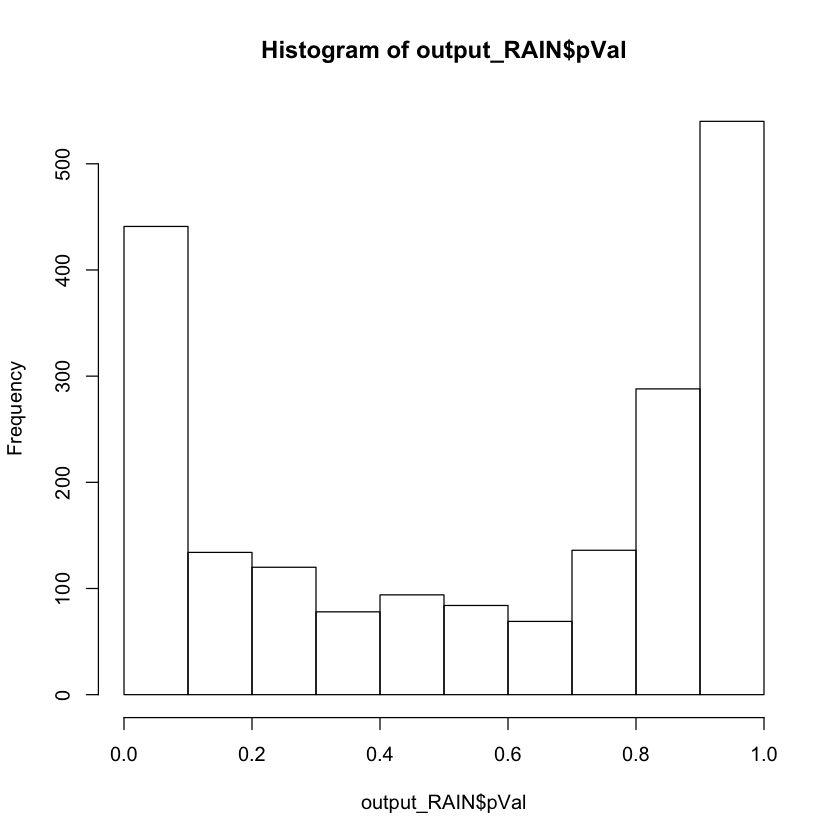

In [5]:
hist(output_RAIN$pVal) # distribution of p-value results

In [6]:
sig<-subset(output_RAIN, pVal < 0.05); dim(sig)[1] # Total number of OTUs with significant rhymicity (p<0.05)

[1] 306

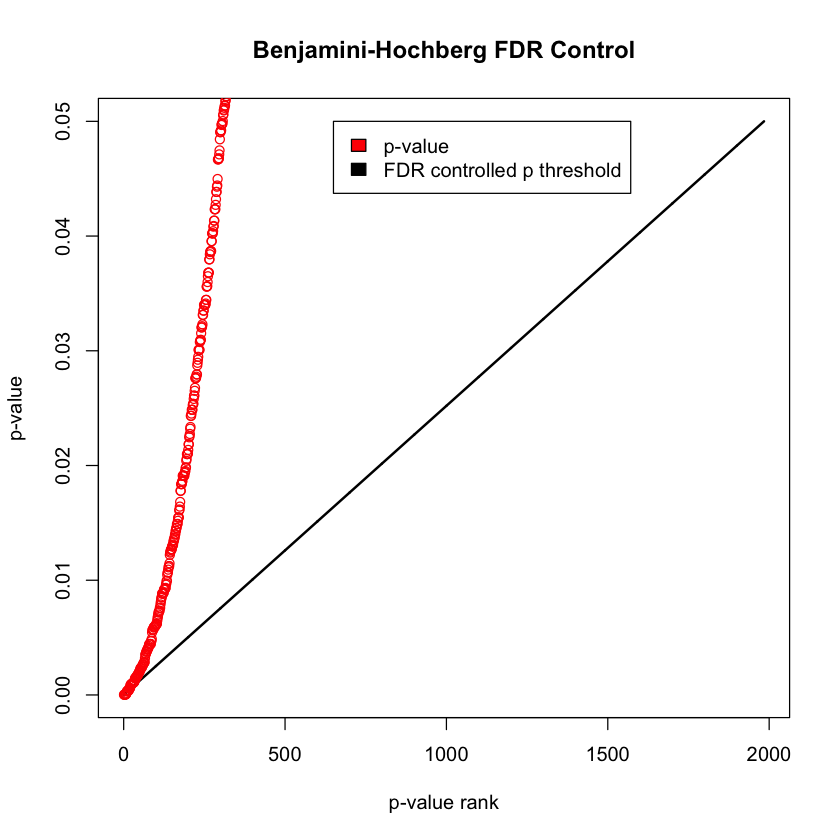

In [7]:
sig$OTU.ID<-row.names(sig); list_of_sig_OTUs<-unique(sig$OTU.ID) # list of OTUs with significant rhythmicity

# Assessing significance
# Bonferroni correction
# This is the LEAST forgiving form of multiple testing correction (least power and least type I error)
bonf_sig<-subset(output_RAIN, pVal <= (0.05/nrow(output_RAIN)))

# Benjamini-Hochberg Correction
#?p.adjust()
fdr_ps<-p.adjust(output_RAIN$pVal,method='BH')
bh_sig<-output_RAIN[which(fdr_ps<=0.05),]

# Adaptive Benjamini-Hochberg Correction (see Benjamini and Hochberg 2001)
# Step 1: Sort p-values in ascending order
abh_ps<-output_RAIN$pVal[order(output_RAIN$pVal,decreasing=FALSE)]

# Step 2: Find p-values smaller than those expected at 5% FDR.
# Rejecting all null hypotheses which have p-values less than their corresponding abh_metric will
# yield the same results as p.adjust(method='BH') at the 0.05 significance level.
q<-0.05 #Significance level
m<-length(abh_ps) #Number of hypotheses tested
abh_metric<-q*(1:m)/m

#For a visualization of what this procedure does -- we consider all red points that fall below the black
# line significant
plot(1:m,abh_metric,type='l',
  xlab='p-value rank',
  ylab='p-value',lwd=2,
  main='Benjamini-Hochberg FDR Control')
points(1:m,abh_ps,col='red')
legend(650,0.05,fill=c('red','black'),legend=c('p-value','FDR controlled p threshold'))

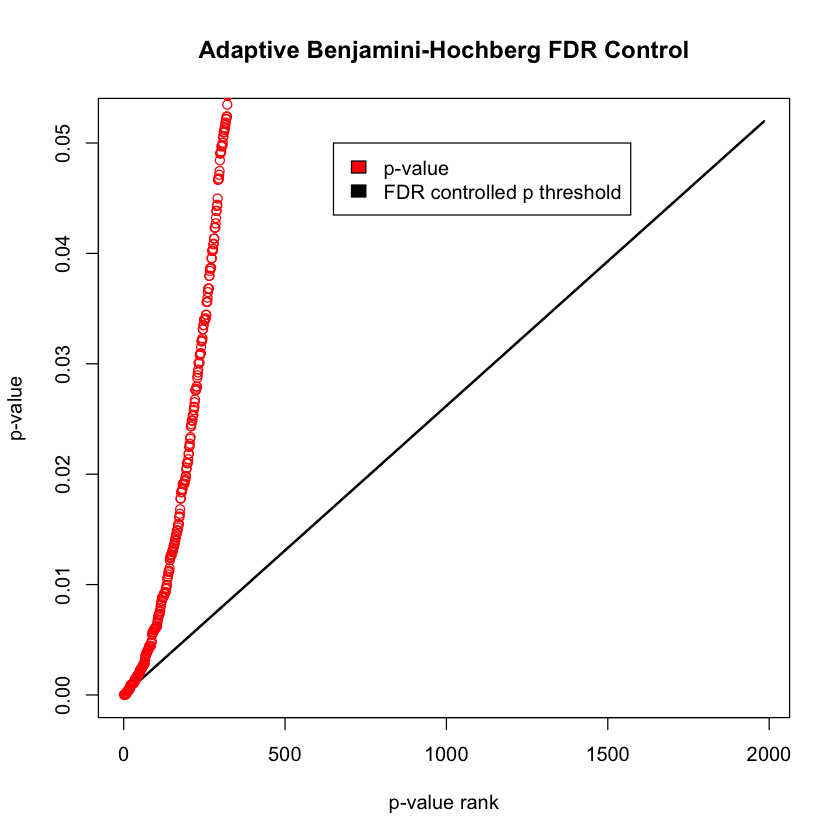

In [8]:
# Step 3: Estimate the number of false null hypotheses according to the procedure outlined
# in Benjamini and Hochberg 2001
s=0
s_i=0
i=1
while(s>=s_i){
  s_i=s
  s=(1-abh_ps[i])/(1+m-i)
  i=i+1
}
m_0<-ceiling(1/s)+1

# Step 4: Find p-values smaller than those expected at 5% FDR for adjusted number of false hypotheses
abh_updated<-(1:length(abh_ps))*0.05/m_0
# For a similar visualization
plot(1:m,abh_updated,type='l',
     xlab='p-value rank',
     ylab='p-value',lwd=2,
     main='Adaptive Benjamini-Hochberg FDR Control')
points(1:m,abh_ps,col='red')
legend(650,0.05,fill=c('red','black'),legend=c('p-value','FDR controlled p threshold'))

In [9]:
# Step 5: Determine which tests resulted in a p-value significant at the 5% level considering FDR
abh_sigs<-output_RAIN[which(output_RAIN$pVal %in% abh_ps[which(abh_ps<=abh_updated)]),]

In [10]:
# Compile list of significantly perodic OTUs with taxonomic identities (use tax_key generated above)
abh_sigs$OTU.ID<-row.names(abh_sigs)
sig_bytax<-left_join(abh_sigs, tax_key, by="OTU.ID")
dim(abh_sigs); dim(sig_bytax)
# Report list of OTUs found to have significant diel rhythmicity
write.table(sig_bytax, file="SigDiel_OTUs.txt", row.names = FALSE, quote = FALSE)

[1] 11  5

[1] 11 16

In [11]:
# Join CLR normalized data with list of significantly periodic OTUs
df_clr2<-df_clr
df_clr2$OTU.ID<-row.names(df_clr)
df_clr3<-left_join(sig_bytax, df_clr2, by="OTU.ID")
unique(df_clr3$Taxa) # What is the overal taxonomic distribution?
head(df_clr3)

[1] "Opisthokonts"  "Alveolates"    "Other/unknown" "Haptophytes"  
[5] "Stramenopiles" "Unassigned"

pVal,phase,peak.shape,period,OTU.ID,taxonomy,Level1,Level2,Level3,Level4,⋯,10_6AM,11_10AM,12_2PM,13_6PM,14_10PM,15_2AM,16_6AM,17_10AM,18_2PM,19_6PM
4.623134e-05,20,20,24,EF196771.1.884_U,Eukaryota; Opisthokonta; Choanoflagellida; Choanoflagellatea; Choanoflagellatea_X; Choanoflagellatea_X_Group_L; Choanoflagellatea_X_Group_L_X; Choanoflagellatea_X_Group_L_X_sp.;,Eukaryota,Opisthokonta,Choanoflagellida,Choanoflagellatea,⋯,-0.5704517,1.0389862,1.03898621,0.12269548,-0.57045170,-0.57045170,-0.5704517,0.12269548,0.5281606,0.12269548
1.085520e-04,4,16,24,EU500115.1.802_U,Eukaryota; Alveolata; Dinophyta; Dinophyceae; Dinophyceae_X; Dinophyceae_XX; Dinophyceae_XXX; Dinophyceae_XXX_sp.;,Eukaryota,Alveolata,Dinophyta,Dinophyceae,⋯,-0.4784585,0.0000000,-0.00845487,1.04759780,0.39701024,0.55116092,0.0000000,-0.29613694,0.1093282,0.90783586
5.577130e-05,24,12,24,FJ217814.1.1521_U,Eukaryota; Alveolata; Dinophyta; Dinophyceae; Dinophyceae_X; Dinophyceae_XX; Azadinium; Azadinium_spinosum;,Eukaryota,Alveolata,Dinophyta,Dinophyceae,⋯,-0.1681654,0.1276205,0.42043464,0.29755735,0.03043203,-0.14246114,-0.3996840,0.01835134,0.3232709,0.07288045
2.649589e-05,24,8,24,FN690303.1.1694_U,Eukaryota; Alveolata; Dinophyta; Dinophyceae; Dinophyceae_X; Dinophyceae_XX; Dinophyceae_XXX; Dinophyceae_XXX_sp.;,Eukaryota,Alveolata,Dinophyta,Dinophyceae,⋯,0.0000000,0.0000000,0.84190955,-0.07438118,-0.76752836,-0.07438118,0.0000000,0.84190955,0.8419095,-0.07438118
4.077949e-04,4,20,24,GQ365768.1.1539_U,Eukaryota; Hacrobia; Telonemia; Telonemia_X; Telonemia_XX; Telonemia-Group-2; Telonemia-Group-2_X; Telonemia-Group-2_X_sp.;,Eukaryota,Hacrobia,Telonemia,Telonemia_X,⋯,0.0000000,0.6096809,-0.48893136,0.89736300,0.20421582,0.20421582,0.0000000,0.20421582,-0.4889314,0.60968093
3.792305e-04,24,8,24,HM749951,Eukaryota; Hacrobia; Haptophyta; Prymnesiophyceae; Prymnesiales; Chrysochromulinaceae; Chrysochromulina; Chrysochromulina_sp.;,Eukaryota,Hacrobia,Haptophyta,Prymnesiophyceae,⋯,0.0000000,0.0000000,0.23104906,0.00000000,-0.46209812,0.00000000,0.0000000,0.00000000,0.0000000,0.00000000


Using df_clr3.OTU.ID, df_clr3.Taxa, df_clr3.taxonomy as id variables


OTU.ID,Taxa,Full taxonomy,variable,value,Time_of_day
EF196771.1.884_U,Opisthokonts,Eukaryota; Opisthokonta; Choanoflagellida; Choanoflagellatea; Choanoflagellatea_X; Choanoflagellatea_X_Group_L; Choanoflagellatea_X_Group_L_X; Choanoflagellatea_X_Group_L_X_sp.;,X1_6PM,0.5281606,Day 1 6PM
EU500115.1.802_U,Alveolates,Eukaryota; Alveolata; Dinophyta; Dinophyceae; Dinophyceae_X; Dinophyceae_XX; Dinophyceae_XXX; Dinophyceae_XXX_sp.;,X1_6PM,0.0000000,Day 1 6PM
FJ217814.1.1521_U,Alveolates,Eukaryota; Alveolata; Dinophyta; Dinophyceae; Dinophyceae_X; Dinophyceae_XX; Azadinium; Azadinium_spinosum;,X1_6PM,0.4249412,Day 1 6PM
FN690303.1.1694_U,Alveolates,Eukaryota; Alveolata; Dinophyta; Dinophyceae; Dinophyceae_X; Dinophyceae_XX; Dinophyceae_XXX; Dinophyceae_XXX_sp.;,X1_6PM,-0.7675284,Day 1 6PM
GQ365768.1.1539_U,Other/unknown,Eukaryota; Hacrobia; Telonemia; Telonemia_X; Telonemia_XX; Telonemia-Group-2; Telonemia-Group-2_X; Telonemia-Group-2_X_sp.;,X1_6PM,0.0000000,Day 1 6PM
HM749951,Haptophytes,Eukaryota; Hacrobia; Haptophyta; Prymnesiophyceae; Prymnesiales; Chrysochromulinaceae; Chrysochromulina; Chrysochromulina_sp.;,X1_6PM,0.0000000,Day 1 6PM


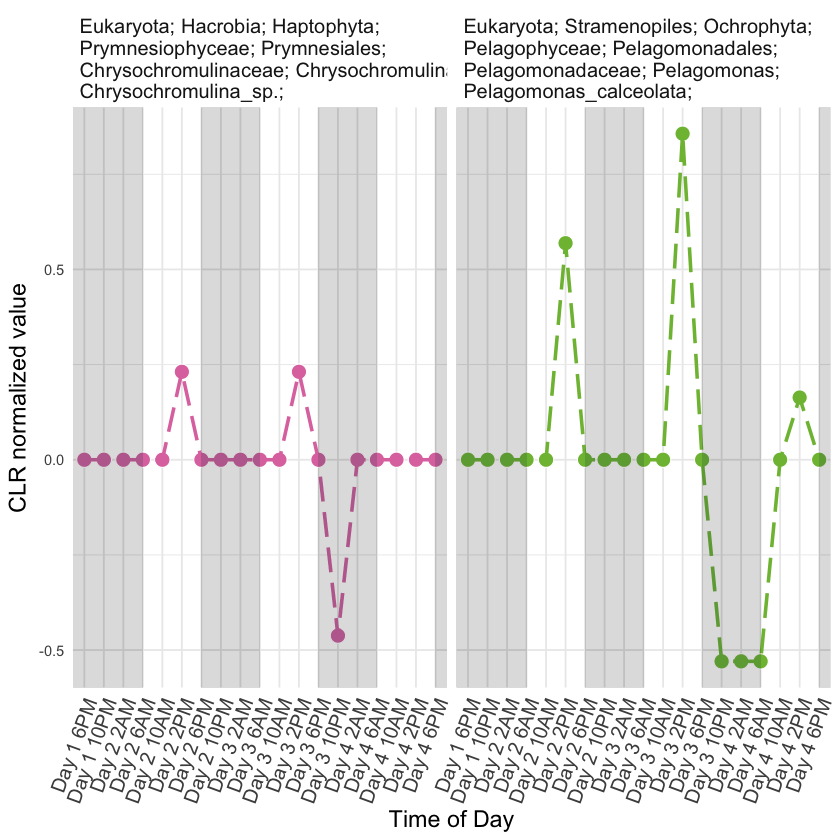

In [18]:
# Plot signal of OTUs with significant periodicity
df_clr4<-melt(data.frame(df_clr3$OTU.ID, df_clr3$Taxa, df_clr3$taxonomy, df_clr3[17:35])) #Extract taxa names and CLR normalied values
df_clr4$Time_of_day<-factor(df_clr4$variable, 
                            levels = c("X1_6PM","X2_10PM","X3_2AM","X4_6AM","X5_10AM","X6_2PM","X7_6PM","X8_10PM","X9_2AM","X10_6AM","X11_10AM","X12_2PM","X13_6PM","X14_10PM","X15_2AM","X16_6AM","X17_10AM","X18_2PM","X19_6PM"), 
                            labels = c("Day 1 6PM","Day 1 10PM","Day 2 2AM","Day 2 6AM","Day 2 10AM","Day 2 2PM","Day 2 6PM","Day 2 10PM","Day 3 2AM","Day 3 6AM","Day 3 10AM","Day 3 2PM","Day 3 6PM","Day 3 10PM","Day 4 2AM","Day 4 6AM","Day 4 10AM","Day 4 2PM","Day 4 6PM"))
colnames(df_clr4)[1:3]<-c("OTU.ID","Taxa","Full taxonomy")
head(df_clr4)
#
# Plot CLR normalized values for those OTUs with significant diel rhythmicity"
diel_plot<-ggplot(df_clr4, aes(x=Time_of_day, y=value, group= OTU.ID))+
    geom_point(size=4,shape=21, color="white", aes(fill=Taxa, group = OTU.ID))+
    geom_line(size=1, linetype = 5, aes(color=Taxa))+
    facet_wrap(OTU.ID ~ `Full taxonomy`,labeller = label_wrap_gen(40))+
    theme_minimal()+
    labs(title="Taxa with significant diel rhythmicity", x = "Time of Day", y = "CLR normalized value")+
    theme(legend.position="none",axis.text.x = element_text(angle=45,hjust=1, vjust=1), 
          strip.text = element_text(hjust=0, size=8))+
    geom_rect(data=NULL,aes(xmin=-Inf,xmax=4,ymin=-Inf,ymax=Inf),color=NA,fill="#737373",alpha=0.01)+
    geom_rect(data=NULL,aes(xmin=7,xmax=10,ymin=-Inf,ymax=Inf),color=NA,fill="#737373",alpha=0.01)+
    geom_rect(data=NULL,aes(xmin=13,xmax=16,ymin=-Inf,ymax=Inf),color=NA,fill="#737373",alpha=0.01)+
    geom_rect(data=NULL,aes(xmin=19,xmax=Inf,ymin=-Inf,ymax=Inf),color=NA,fill="#737373",alpha=0.01)


diel_plot<-ggplot(df_clr4, aes(x=Time_of_day, y=value, group= OTU.ID))+
    geom_point(size=4,shape=21, color="white", aes(fill=Taxa, group = OTU.ID))+
    geom_line(size=1, linetype = 5, aes(color=Taxa))+
    facet_wrap(~`Full taxonomy`,labeller = label_wrap_gen(40))+
    theme_minimal()+
    labs(x = "Time of Day", y = "CLR normalized value")+
    theme(legend.position="none",axis.text.x = element_text(angle=70,hjust=1, vjust=1,size=12), 
          strip.text = element_text(hjust=0, size=12),axis.title=element_text(size=14))+
    geom_rect(data=NULL,aes(xmin=-Inf,xmax=4,ymin=-Inf,ymax=Inf),color=NA,fill="#737373",alpha=0.01)+
    geom_rect(data=NULL,aes(xmin=7,xmax=10,ymin=-Inf,ymax=Inf),color=NA,fill="#737373",alpha=0.01)+
    geom_rect(data=NULL,aes(xmin=13,xmax=16,ymin=-Inf,ymax=Inf),color=NA,fill="#737373",alpha=0.01)+
    geom_rect(data=NULL,aes(xmin=19,xmax=Inf,ymin=-Inf,ymax=Inf),color=NA,fill="#737373",alpha=0.01)
#
# Plot a subset
tax_of_interest<-c("Stramenopiles", "Haptophytes")
diel_plot %+% subset(df_clr4, Taxa %in% tax_of_interest)+
    scale_fill_manual(values=c("#de77ae", "#7fbc41"))+
    scale_color_manual(values=c("#de77ae", "#7fbc41"))

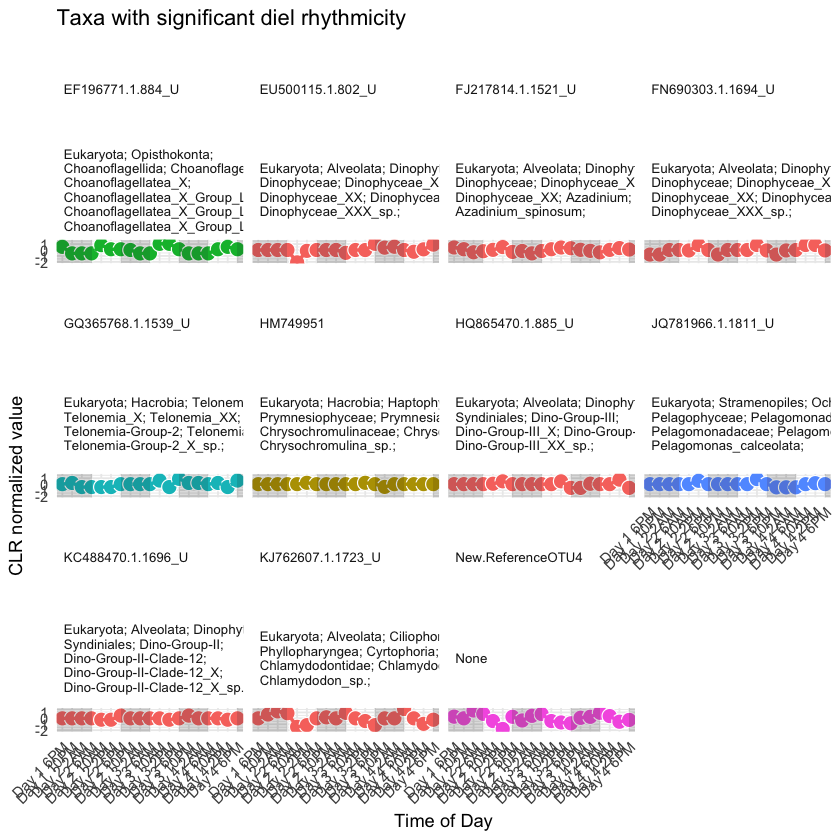

In [14]:
# Plot all
diel_plot